In [43]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [7]:
data = pd.read_excel("dataset.xlsx", parse_dates=['Date'])

In [67]:
#Splitting for ammonia column values
X = data['ammonia'].values
train, test = X[0:-1210], X[-1210:]

### Persistance base model

In [63]:
def persistence(train, test , label):
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # make prediction
        predictions.append(history[-1]) #persistence based on one day prior predictions
        # observation
        history.append(test[i])
     # line plot of observed vs predicted
    plt.plot(test, label = 'test')
    plt.plot(predictions , label = 'predictions')
    plt.title(label)
    plt.legend(loc = 'best')
    plt.show()
    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test,predictions)
    print('RMSE: %.3f' % rmse)
    print('R2 score : %.3f' %r2)

In [64]:
data.columns

Index(['Date', 'sediment', 'ammonia', 'nitrite and nitrates', 'total nitrogen',
       'orthophosphate', 'total phosphorus'],
      dtype='object')

In [65]:
lis = ['sediment', 'ammonia', 'nitrite and nitrates', 'total nitrogen',
       'orthophosphate', 'total phosphorus']

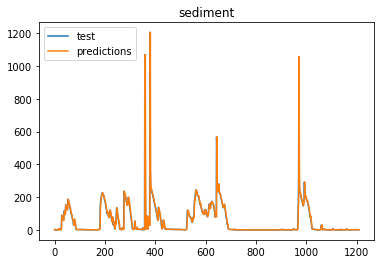

RMSE: 61.053
R2 score : 0.616


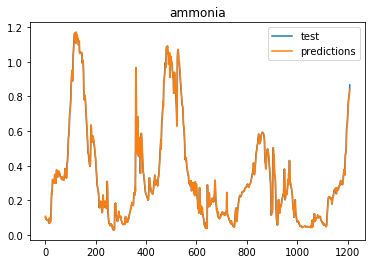

RMSE: 0.033
R2 score : 0.987


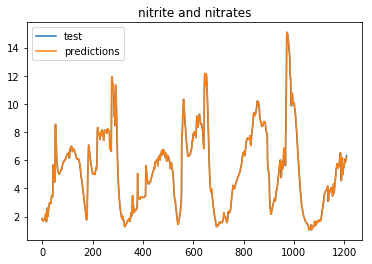

RMSE: 0.349
R2 score : 0.984


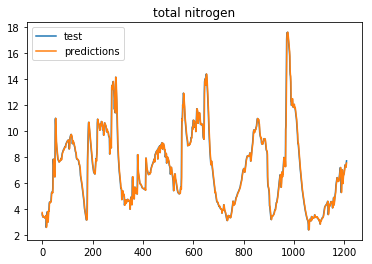

RMSE: 0.369
R2 score : 0.984


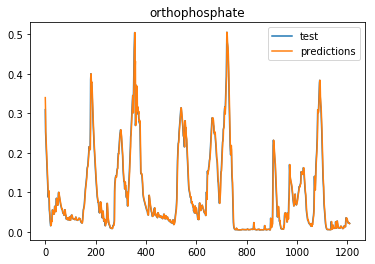

RMSE: 0.013
R2 score : 0.983


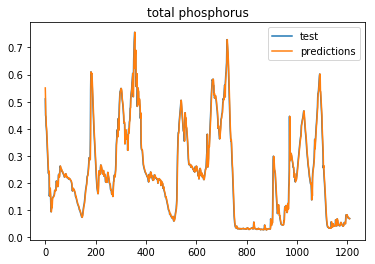

RMSE: 0.019
R2 score : 0.987


In [66]:
for i in lis:
    X = data[i].values
    train, test = X[:-1210], X[-1210:]
    persistence(train,test,i)
    

- The reason for getting high performance on an untrained persistent model is because of the high autocorrelation existing between values in t , t+1 (Refer to autocorrelation plots above)
- The series might be a random walk in nature, thus the results of a persistent model might be highly misleading


### Rechecking series stationarity

In [41]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [42]:
for i in lis:
    print(i)
    kpss_test(data[i])

sediment
Results of KPSS Test:
Test Statistic            0.07023
p-value                   0.10000
Lags Used                34.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64
ammonia
Results of KPSS Test:
Test Statistic            0.075408
p-value                   0.100000
Lags Used                34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
nitrite and nitrates
Results of KPSS Test:
Test Statistic            0.025369
p-value                   0.100000
Lags Used                34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
total nitrogen
Results of KPSS Test:
Test Statistic            0.036998
p-value                   0.100000
Lags Used       

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning:

Again all results show series to be stationary. Therefore the second point mentioned above is discarded as random walk series is always stationary

# LSTM Based approach (Univariate Version)

### Converting timeseries to input-output format for lstm network
- Making values at t+1 output for input values at t

In [84]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [85]:
X = data['ammonia'].values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

         0        0
0  0.00000  1.14291
1  1.14291  1.18808
2  1.18808  1.19614
3  1.19614  1.18993
4  1.18993  1.18742


#### Scaling data in range -1 to 1 for hyperbolic tangent activation function in LSTM

In [91]:
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

### Fitting model

In [97]:
# fit an LSTM network to training data
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

ImportError: Could not find 'cudnn64_7.dll'. TensorFlow requires that this DLL be installed in a directory that is named in your %PATH% environment variable. Note that installing cuDNN is a separate step from installing CUDA, and this DLL is often found in a different directory from the CUDA DLLs. You may install the necessary DLL by downloading cuDNN 7 from this URL: https://developer.nvidia.com/cudnn

In [93]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 

### Implementing function

In [94]:
supervised = timeseries_to_supervised(data['ammonia'].values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-1210], supervised_values[-1210:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 100, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(data['ammonia'].values[-1210:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(data['ammonia'].values[-1210:])
pyplot.plot(predictions)
pyplot.show()

NameError: name 'Sequential' is not defined